In [284]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


fecboのm=2の場合を二次計画法で実装、cvxoptのライブラリーにあったけど、データによって成功したり失敗したりする
原因としてはAのランク（制約条件だと思う）が低いから、成功しない
主双対パス追跡法の実装は出来てない、
このコードは途中で諦めてあって、未完成(2021.11.25現在)
12/1 これってAとかにクラスタサイズKを入れてないんじゃないか、あと帰属度が1になるって条件も入ってない気がする\
1/11 できた

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#sysはコマンドライン引数
import sys
import csv
#cvxoptのインポート
import numpy as np
import cvxopt
from cvxopt import matrix
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
df = pd.read_csv("output.csv",header=None)

#クラスタ数宣言
c=5
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納

X_size,dimension = X.shape
#Kはクラスタサイズ(fecboの場合整数に限らない)
K=X_size/c
#K=2
centroids = X[np.random.choice(X_size,c)]
distances=np.zeros((X_size,c))

二次計画法

In [286]:
#pにはd11,d12,d13,,,,d21,d22,,,dn1,,dncの順でリスト作る
p=[]
for i in range(X_size):
    for j in range(c):
        p.append(np.sum((X[i]-centroids[j])**2))
#三項演算子でデータ点をクラスタ中心にしている場合、距離dを少しずらす
p = [0.0000000001 if i == 0 else i for i in p]
print(p)

[0.04769473555599996, 1e-10, 0.115661594978, 1e-10, 0.04769473555599996, 0.044534055555999985, 0.00032017111199999967, 0.11002489557800005, 0.00032017111199999967, 0.044534055555999985, 0.07641761555599996, 0.034870411111999976, 0.13465901557800003, 0.034870411111999976, 0.07641761555599996, 0.041001691111999986, 0.0007403055559999994, 0.10412108497800004, 0.0007403055559999994, 0.041001691111999986, 1e-10, 0.04769473555599996, 0.014995290578000024, 0.04769473555599996, 1e-10, 0.08168416388899997, 0.03822570388899998, 0.14067954388900006, 0.03822570388899998, 0.08168416388899997, 0.014995290578000024, 0.115661594978, 1e-10, 0.115661594978, 0.014995290578000024, 0.010834891111999997, 0.014240305555999986, 0.04962768497800004, 0.014240305555999986, 0.010834891111999997, 0.002075713888999991, 0.034195399444999997, 0.024758896689000005, 0.034195399444999997, 0.002075713888999991, 0.16898525111199994, 0.037423585556, 0.28432386497800005, 0.037423585556, 0.16898525111199994]


In [258]:
len(p)

50

In [287]:
p_1 = 1/2 * np.diag(p)
P = matrix(p_1.astype('float'))
P

<50x50 matrix, tc='d'>

In [288]:
q = matrix(np.zeros(len(p)).astype('float'))
q

<50x1 matrix, tc='d'>

In [302]:
g = [-1 for i in range(len(p))]
G = matrix(np.diag(g).astype("float"))
G

<50x50 matrix, tc='d'>

In [303]:
h1 = np.zeros(len(p))
h = matrix(h1)
h

<50x1 matrix, tc='d'>

In [313]:
b1 = np.ones(X_size)
b1 = np.append(b1,[K,K,K,K])
b = matrix(b1.astype('float'))
b

<14x1 matrix, tc='d'>

In [314]:
b1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2.])

In [315]:
#A作成
s_pre1=[]
s_pre=[]
for i in range(X_size):
    for j in range(X_size*c):
        if j==c*i or j==c*i+1 or j==c*i+2 or j==c*i+3 or j==c*i+4:
            s_pre1.append(1)
        else:
            s_pre1.append(0)
    s_pre.append(s_pre1)
    s_pre1=[]
s = np.array(s_pre).astype('float')
#---------ここまででu_ki=1---------
a0 = np.zeros(50)
a1 = np.zeros(50)
a2 = np.zeros(50)
a3 = np.zeros(50)
#a4 = np.zeros(50)
a0[::5]=1
a1[1::5]=1
a2[2::5]=1
a3[3::5]=1
# a4[4::5]=1
aa = np.stack([a0,a1,a2,a3])
# -----ここまでu_ki=Kの作成------
a = np.concatenate([s,aa])
A = matrix(a.astype('float'))

In [316]:
a

array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [317]:
sol = cvxopt.solvers.qp(P,q,G=G,h=h,A=A,b=b)
print(sol)
print(sol['x'])
print(sol['primal objective'])

     pcost       dcost       gap    pres   dres
 0:  2.5355e-02 -1.0069e+01  1e+01  1e-16  9e+00
 1:  2.5107e-02 -1.6504e-01  2e-01  3e-16  2e-01
 2:  1.9252e-02 -1.6202e-02  4e-02  2e-16  2e-02
 3:  1.3760e-02  8.2906e-03  5e-03  9e-16  7e-18
 4:  1.2598e-02  1.2253e-02  3e-04  3e-16  5e-18
 5:  1.2460e-02  1.2446e-02  1e-05  2e-15  3e-18
 6:  1.2455e-02  1.2455e-02  7e-07  3e-14  4e-18
 7:  1.2455e-02  1.2455e-02  1e-08  2e-13  4e-18
Optimal solution found.
{'x': <50x1 matrix, tc='d'>, 'y': <14x1 matrix, tc='d'>, 's': <50x1 matrix, tc='d'>, 'z': <50x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.2653558371091542e-08, 'relative gap': 1.0159216552117004e-06, 'primal objective': 0.012455262825834125, 'dual objective': 0.012455250172273136, 'primal infeasibility': 1.6877945653523456e-13, 'dual infeasibility': 3.924889547116102e-18, 'primal slack': 1.2465715631291554e-08, 'dual slack': 9.90231417239862e-12, 'iterations': 7}
[ 8.99e-02]
[ 3.79e-01]
[ 6.16e-02]
[ 3.79e-01]
[ 8.99e-02]
[ 9

In [318]:
u = np.array(sol['x'])
u_list = u.reshape([X_size,c])
print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[2. 2. 2. 2. 2.]


In [319]:
u_list

array([[8.98735364e-02, 3.79347662e-01, 6.15576032e-02, 3.79347662e-01,
        8.98735364e-02],
       [9.88992419e-02, 3.68209382e-01, 6.57827514e-02, 3.68209382e-01,
        9.88992419e-02],
       [1.76220791e-01, 2.63256976e-01, 1.21044465e-01, 2.63256976e-01,
        1.76220791e-01],
       [1.10929170e-01, 3.53623449e-01, 7.08947624e-02, 3.53623449e-01,
        1.10929170e-01],
       [4.05525111e-01, 3.17692121e-08, 1.88949714e-01, 3.17692121e-08,
        4.05525111e-01],
       [1.75672339e-01, 2.63256223e-01, 1.22142875e-01, 2.63256223e-01,
        1.75672339e-01],
       [1.24657156e-08, 1.45410249e-08, 9.99999946e-01, 1.45410249e-08,
        1.24657156e-08],
       [4.13045337e-01, 1.33197845e-02, 1.47269756e-01, 1.33197845e-02,
        4.13045337e-01],
       [4.24967006e-01, 5.05433433e-08, 1.50065887e-01, 5.05433433e-08,
        4.24967006e-01],
       [1.04867454e-01, 3.58986426e-01, 7.22922397e-02, 3.58986426e-01,
        1.04867454e-01]])

In [321]:
np_cluster = np.argmax(u_list,axis=1)
np_cluster

array([3, 1, 1, 1, 4, 1, 2, 0, 0, 1])

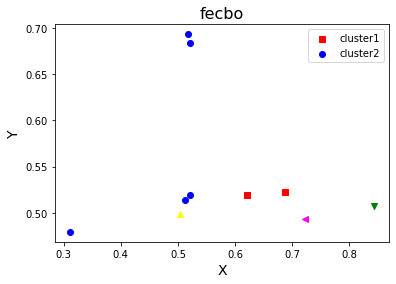

In [322]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])

ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2'])  # 凡例を表示

plt.show()

fig.savefig("img2d.pdf")

ここまでが完成コード

In [7]:
b = matrix(np.array([1,1,1,1,1,1,1,1,1,1,5,5]).astype('float'))
a = np.zeros((12,20))
np.put(a, [0, 1,22,23,44,45,66,67,88,89,110,111,132,133,154,155,176,177,198,199], 1)
a[10:11:1,::2]=1
a[11:12:1,1::2]=1
A = matrix(a)

sol = cvxopt.solvers.qp(P,q,G=G,h=h,A=A,b=b)
print(sol)
print(sol['x'])
print(sol['primal objective'])

ValueError: Rank(A) < p or Rank([P; A; G]) < n

In [8]:
#Aのランクがない
np.linalg.matrix_rank(A)

11

In [10]:
print(A)

[ 1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  1.00e+00  1.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  1.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 ... ]
[ 1.00e+00  0.00e+00  1.00e+00  0.00e+00  1.00e+00  0.00e+00  1.00e+00 ... ]
[ 0.00e+00  1.00e+00  0.00e+00  1.00e+00  0.00e+00  1.00e+00  0.00e+00 ... ]



In [45]:
u = np.array(sol['x'])
print(u)
for i in range(0,20,2):
    print(u[i]+u[i+1])

[[8.71829410e-01]
 [1.28170590e-01]
 [8.69000775e-01]
 [1.30999225e-01]
 [6.69562970e-01]
 [3.30437030e-01]
 [8.55440805e-01]
 [1.44559195e-01]
 [1.80685139e-06]
 [9.99998193e-01]
 [6.66413497e-01]
 [3.33586503e-01]
 [7.32805528e-02]
 [9.26719447e-01]
 [2.19563060e-01]
 [7.80436940e-01]
 [5.23693055e-06]
 [9.99994763e-01]
 [7.74901887e-01]
 [2.25098113e-01]]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]


vの更新

In [69]:
u2=np.power(u,2)
u2_list = u2.tolist()
#分母計算
v0_denominator=0
v1_denominator=0
for i in range(0,20,2):
    v0_denominator += u2[i]
for i in range(1,20,2):
    v1_denominator += u2[i]
#print(v0_denominator,v1_denominator)
#分子計算
v0_numerator = 0
v1_numerator = 0
for i in range(10):
    v0_numerator += u2_list[i*2]*X[i]
    v1_numerator += u2_list[1+i*2]*X[i]
#print(v0_numerator,v1_numerator)
v=[0 for i in range(2)]
v[0] = v0_numerator / v0_denominator
v[1] = v1_numerator / v1_denominator
print("クラスター中心はcluster1:{},cluster2:{}".format(v[0],v[1]))

IndexError: index 2 is out of bounds for axis 0 with size 2

In [44]:
cluster = [0 for i in range(10)]
u_list = u.tolist()
for i in range (10):
    if u[i*2]>u[1+i*2]:
        cluster[i] = 0
    else:
        cluster[i] = 1
np_cluster =np.array(cluster)

In [46]:
cluster

[1, 1, 1, 1, 0, 1, 0, 0, 0, 1]

In [47]:
a = np.zeros((11,20))

In [48]:
v0000

array([5.])

In [49]:
v1111

array([5.])

In [50]:
P

<20x20 matrix, tc='d'>

In [51]:
q

<20x1 matrix, tc='d'>

In [52]:
G

<20x20 matrix, tc='d'>

In [53]:
h

<20x1 matrix, tc='d'>

In [54]:
A

<12x20 matrix, tc='d'>

In [55]:
b

<12x1 matrix, tc='d'>

In [56]:
# 2次最適化問題
#
P = 2*matrix([ [2, .5], [.5, 1] ])
q = matrix([1.0, 1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol = cvxopt.solvers.qp(P,q,G,h,A,b)
print(sol)
print(sol['x'])
print(sol['primal objective'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  1e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  1e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  0e+00  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  2e-16  5e-08
Optimal solution found.
{'x': <2x1 matrix, tc='d'>, 'y': <1x1 matrix, tc='d'>, 's': <2x1 matrix, tc='d'>, 'z': <2x1 matrix, tc='d'>, 'status': 'optimal', 'gap': 1.0527028380515324e-07, 'relative gap': 5.6144154514913756e-08, 'primal objective': 1.8750000000000182, 'dual objective': 1.8749998947297344, 'primal infeasibility': 2.2887833992611187e-16, 'dual infeasibility': 5.314759333739872e-08, 'primal slack': 0.2500000952702476, 'dual slack': 1.0000000000000035e-08, 'iterations': 4}
[ 2.50e-01]
[ 7.50e-01]

1.8750000000000182


In [57]:
m = np.array([[1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
              [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],[0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]]).astype('float')

In [58]:
print(np.all(a == m))

True


In [59]:
print("a\na")

a
a
